In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video
import torch.nn as nn
import gymnasium as gym
from bbrl.utils.chrono import Chrono
import matplotlib
import matplotlib.pyplot as plt
from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial
import tools 
matplotlib.use("TkAgg")
import gymnasium as gym
import tools
from scipy.stats import ttest_ind
from optuna.samplers import TPESampler, RandomSampler, NSGAIISampler, GridSampler
# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)

In [72]:
# Define global constants 
NB_EPISODES = 400

AC_PARAMS = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "human",  # "rgb_array" to render the maze
    },
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",
    "nb_episodes": NB_EPISODES,
    "timeout": 200,
    "render": True,
    "nb_repeats": 5,
    "gamma": 0.8,
    
    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

In [73]:
def compute_central_tendency_and_error(id_central, id_error, sample):

    try:
        id_error = int(id_error)
    except:
        pass

    if id_central == "mean":
        central = np.nanmean(sample, axis=1)
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high

def run_test(test_id, data1, data2, alpha=0.05):
    """
    Compute tests comparing data1 and data2 with confidence level alpha
    :param test_id: (str) refers to what test should be used
    :param data1: (np.ndarray) sample 1
    :param data2: (np.ndarray) sample 2
    :param alpha: (float) confidence level of the test
    :return: (bool) if True, the null hypothesis is rejected
    """
    data1 = data1.squeeze()
    data2 = data2.squeeze()
    n1 = data1.size
    n2 = data2.size

    # perform Welch t-test":
    _, p = ttest_ind(data1, data2, equal_var=False)
    return p < alpha

def perform_test(perf1, perf2, name1, name2, sample_size=20, downsampling_fact=5, confidence_level=0.01):

    perf1 = perf1.transpose()
    perf2 = perf2.transpose()
    nb_datapoints = perf1.shape[1]
    nb_steps = perf1.shape[0]

    legend = [name1, name2]

    # what do you want to plot ?
    id_central = 'mean' # "median"  # 
    id_error = 80  # (percentiles), also: 'std', 'sem'

    test_id = "Welch t-test"  # recommended
    
    sample1 = perf1[:, np.random.randint(0, nb_datapoints, sample_size)]
    sample2 = perf2[:, np.random.randint(0, nb_datapoints, sample_size)]

    steps = np.arange(0, nb_steps, downsampling_fact)
    sample1 = sample1[steps, :]
    sample2 = sample2[steps, :]

    # test
    sign_diff = np.zeros([len(steps)])
    for i in range(len(steps)):
        sign_diff[i] = run_test(
            test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
        )

    central1, low1, high1 = compute_central_tendency_and_error(
        id_central, id_error, sample1
    )
    central2, low2, high2 = compute_central_tendency_and_error(
        id_central, id_error, sample2
    )

    # plot
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    lab1 = plt.xlabel("training steps")
    lab2 = plt.ylabel("performance")

    plt.plot(steps, central1, linewidth=10)
    plt.plot(steps, central2, linewidth=10)
    plt.fill_between(steps, low1, high1, alpha=0.3)
    plt.fill_between(steps, low2, high2, alpha=0.3)
    leg = ax.legend(legend, frameon=False)

    # plot significative difference as dots
    idx = np.argwhere(sign_diff == 1)
    y = max(np.nanmax(high1), np.nanmax(high2))
    plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")

    # style
    for line in leg.get_lines():
        line.set_linewidth(10.0)
    ax.spines["top"].set_linewidth(5)
    ax.spines["right"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.spines["left"].set_linewidth(5)

    plt.savefig(
        f"./stats_priere/{name1}_{name2}.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    )
    # plt.show()

# TEST

In [74]:
# Total number of trials and the number of values for each hyperparameter
n_trials = 400  # Chosen for sufficient exploration of the search space

# The number of independent runs per trial to average results and reduce variability.
n_runs = 3  # Ensures stability of results across multiple runs

# The number of episodes per trial

AC_PARAMS = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "rgb_array",  # "human" to render the maze
    },
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",
    "nb_episodes": NB_EPISODES,
    "timeout": 200,
    "render": True,
    "nb_repeats": 5,
    "gamma": 0.8,

    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }
env = tools.create_maze_from_params(AC_PARAMS)

alpha_actor = AC_PARAMS['alpha_actor']
alpha_critic = AC_PARAMS['alpha_critic']
gamma = AC_PARAMS['alpha_critic'] 
nb_episodes = AC_PARAMS['nb_episodes']
timeout = AC_PARAMS['timeout']
n_runs = AC_PARAMS['nb_repeats']
AC_PARAMS['nb_repeats'] = "human"

In [75]:
%matplotlib inline
import pickle
import warnings
import numpy as np


# Load the file while ignoring incompatible numpy objects
with open('optimization_results_3.pkl', 'rb') as f:
    results = pickle.load(f, encoding='latin1')


# Number of episodes and repetitions
n_episodes = 150
n_runs = 100  # You can adjust the number of runs for better statistical power

# Naive hyper-parameters (0.5, 0.5)
naive_params = {'alpha_actor': 0.5, 'alpha_critic': 0.5}

# Relancer l'entraînement avec naïve tuning et les meilleurs hyper-paramètres
learning_curves = {}  # Dictionnaire pour stocker les courbes d'apprentissage

# Collect naive tuning learning curves
print("\nCollecting naive tuning (0.5, 0.5) learning curves...")
naive_learning_curves = []
for run in range(n_runs):
    env = tools.create_maze_from_params(AC_PARAMS)
    print(f"Run {run + 1}/{n_runs} for naive tuning...")
    _, _, learning_curve, _, _, _ = tools.naive_actor_critic(env, naive_params['alpha_actor'], naive_params['alpha_critic'], AC_PARAMS['gamma'], n_episodes, AC_PARAMS['timeout'], render=False)
    naive_learning_curves.append(learning_curve)
learning_curves["naive"] = np.array(naive_learning_curves)

# Collect learning curves for each best hyper-parameters found from the results
for result_key, result_value in results.items():
    print(f"\nCollecting learning curves for {result_key}...")
    
    best_params = result_value["best_params"]
    repeated_learning_curves = []

    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs} for {result_key}")
        env = tools.create_maze_from_params(AC_PARAMS)
        _, _, learning_curve, _, _, _ = tools.naive_actor_critic(env, best_params['alpha_actor'], best_params['alpha_critic'], AC_PARAMS['gamma'], n_episodes, AC_PARAMS['timeout'], render=False)
        repeated_learning_curves.append(learning_curve)

    # Store the learning curves for the current result_key
    learning_curves[result_key] = np.array(repeated_learning_curves)

# At this point, `learning_curves` will contain the learning curves for naive tuning
# as well as for the best hyperparameters of each result in the `results` dictionary.



Run 1/100 for naive tuning...
Run 2/100 for naive tuning...
Run 3/100 for naive tuning...
Run 4/100 for naive tuning...
Run 5/100 for naive tuning...
Run 6/100 for naive tuning...
Run 7/100 for naive tuning...
Run 8/100 for naive tuning...
Run 9/100 for naive tuning...
Run 10/100 for naive tuning...
Run 11/100 for naive tuning...
Run 12/100 for naive tuning...
Run 13/100 for naive tuning...
Run 14/100 for naive tuning...
Run 15/100 for naive tuning...
Run 16/100 for naive tuning...
Run 17/100 for naive tuning...
Run 18/100 for naive tuning...
Run 19/100 for naive tuning...
Run 20/100 for naive tuning...
Run 21/100 for naive tuning...
Run 22/100 for naive tuning...
Run 23/100 for naive tuning...
Run 24/100 for naive tuning...
Run 25/100 for naive tuning...
Run 26/100 for naive tuning...
Run 27/100 for naive tuning...
Run 28/100 for naive tuning...
Run 29/100 for naive tuning...
Run 30/100 for naive tuning...
Run 31/100 for naive tuning...
Run 32/100 for naive tuning...
Run 33/100 for n

Testing value_norm_Grid Search vs naive...
Testing value_norm_Random Search vs naive...
Testing value_norm_TPE (Bayesian Optimization) vs naive...
Testing value_norm_NSGA-II vs naive...
Testing convergence_time_Grid Search vs naive...
Testing convergence_time_Random Search vs naive...
Testing convergence_time_TPE (Bayesian Optimization) vs naive...
Testing convergence_time_NSGA-II vs naive...
Testing cumulative_reward_Grid Search vs naive...
Testing cumulative_reward_Random Search vs naive...
Testing cumulative_reward_TPE (Bayesian Optimization) vs naive...
Testing cumulative_reward_NSGA-II vs naive...
Testing discounted_cumulative_reward_Grid Search vs naive...
Testing discounted_cumulative_reward_Random Search vs naive...
Testing discounted_cumulative_reward_TPE (Bayesian Optimization) vs naive...
Testing discounted_cumulative_reward_NSGA-II vs naive...
Testing temporal_difference_error_Grid Search vs naive...
Testing temporal_difference_error_Random Search vs naive...
Testing tempor

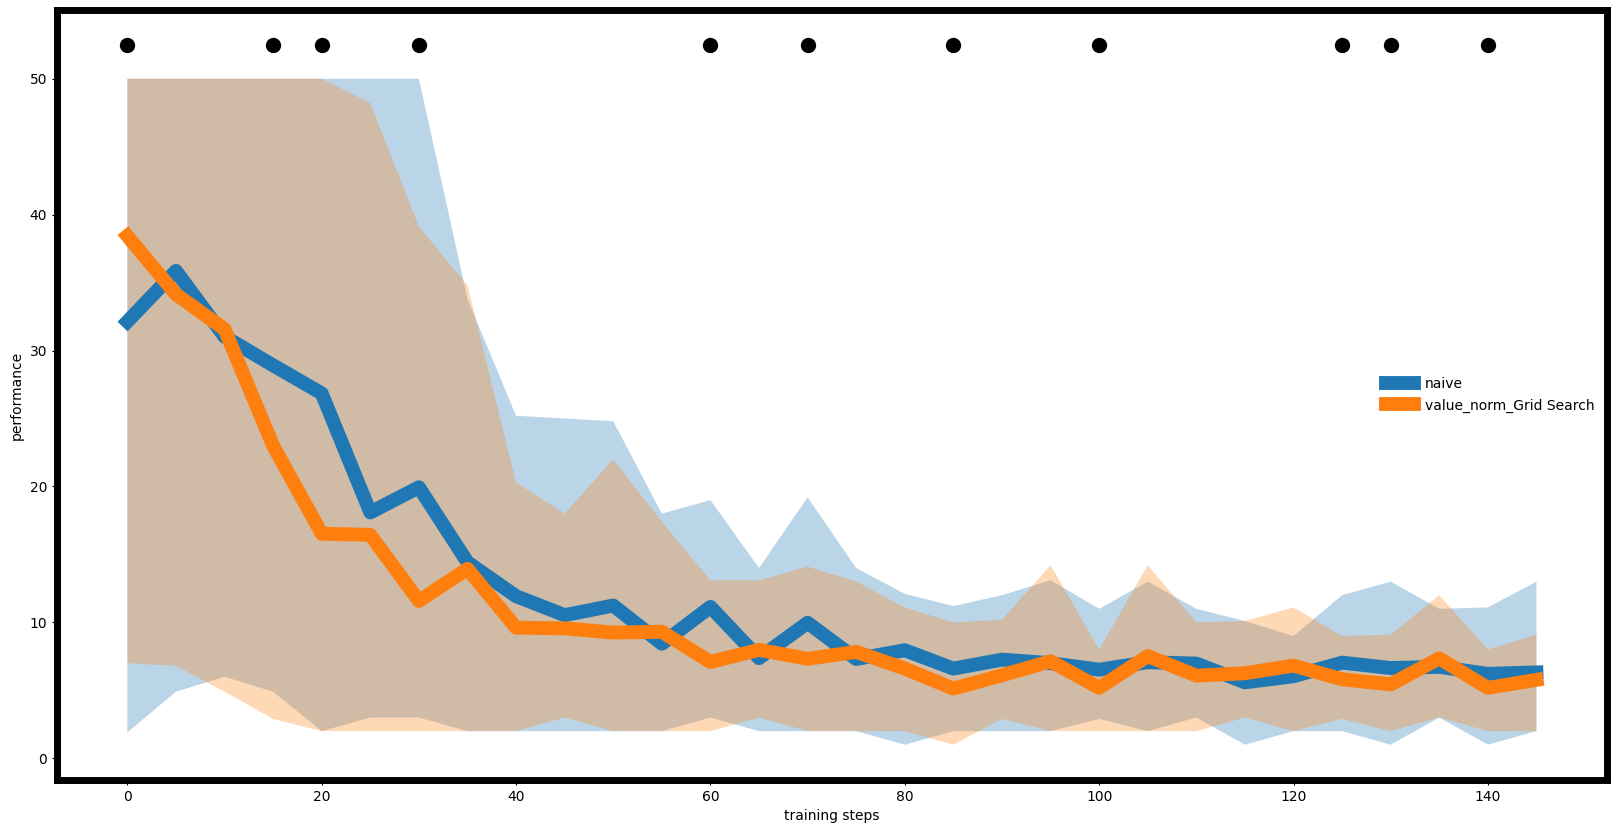

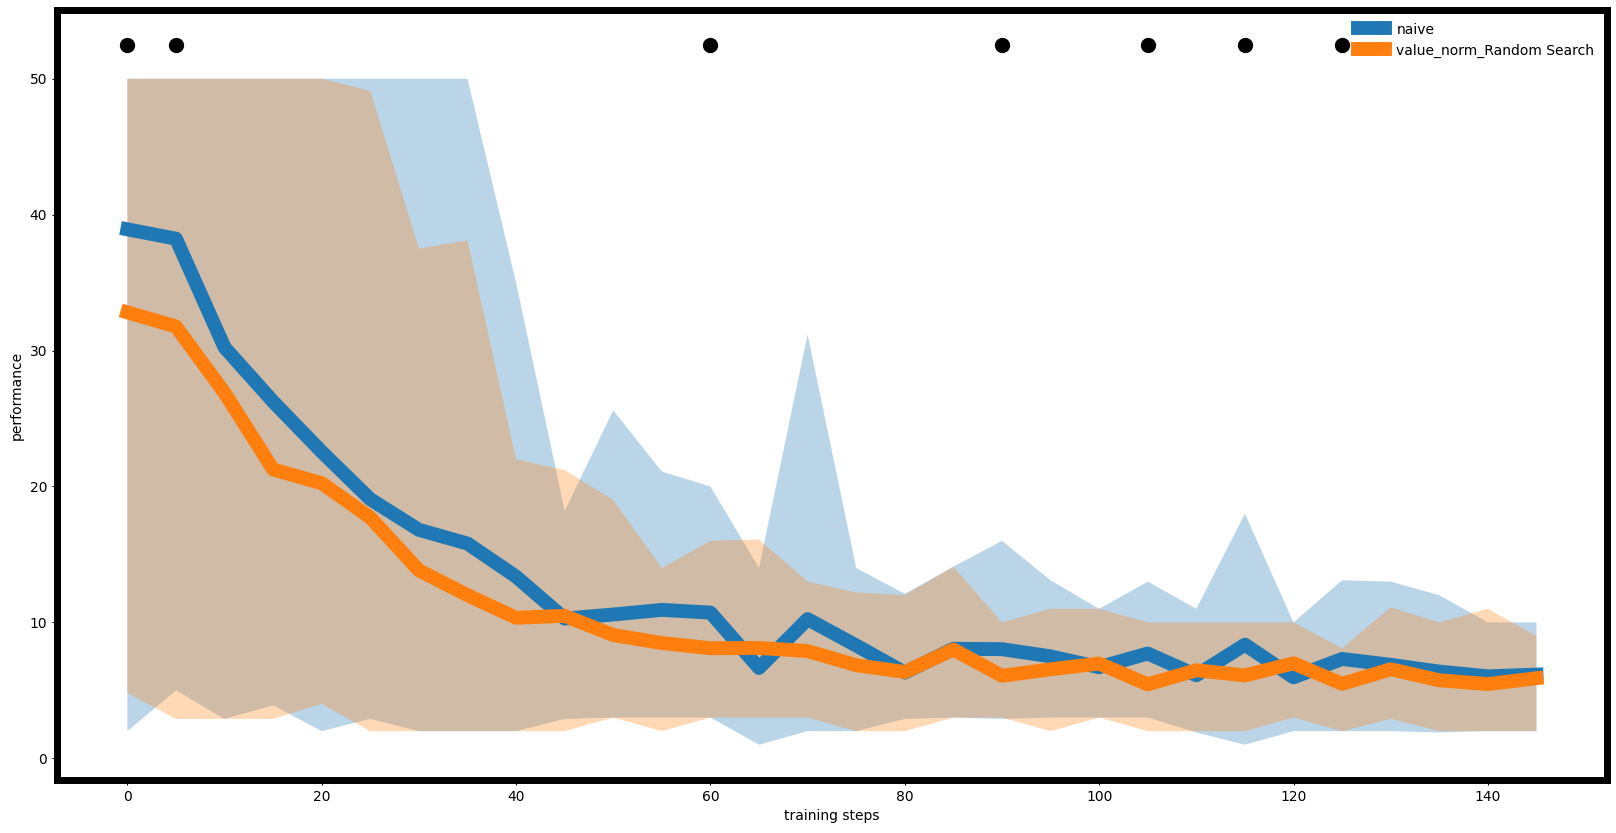

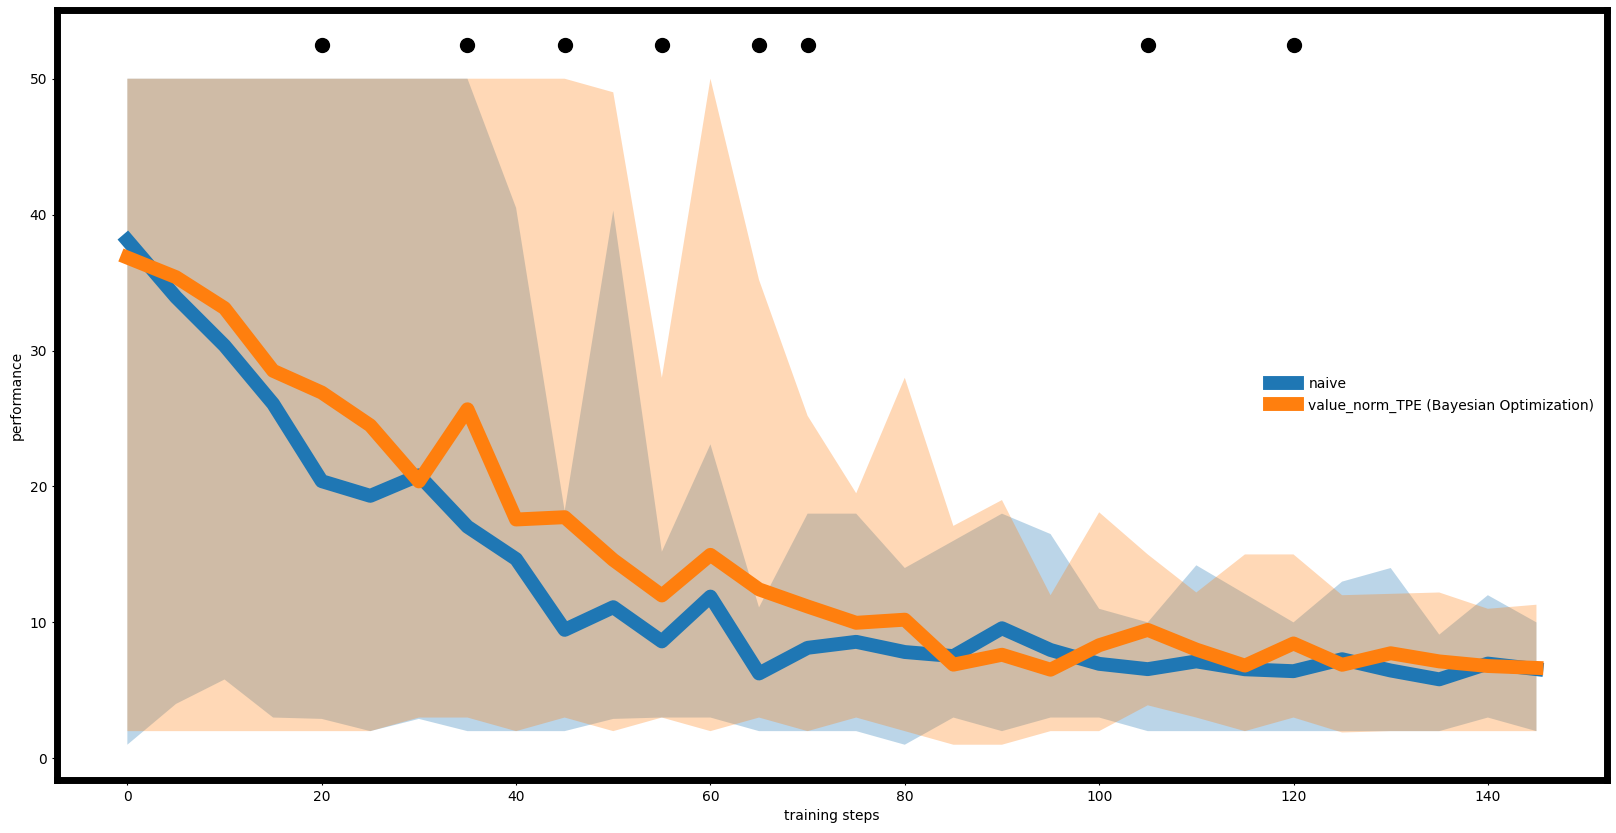

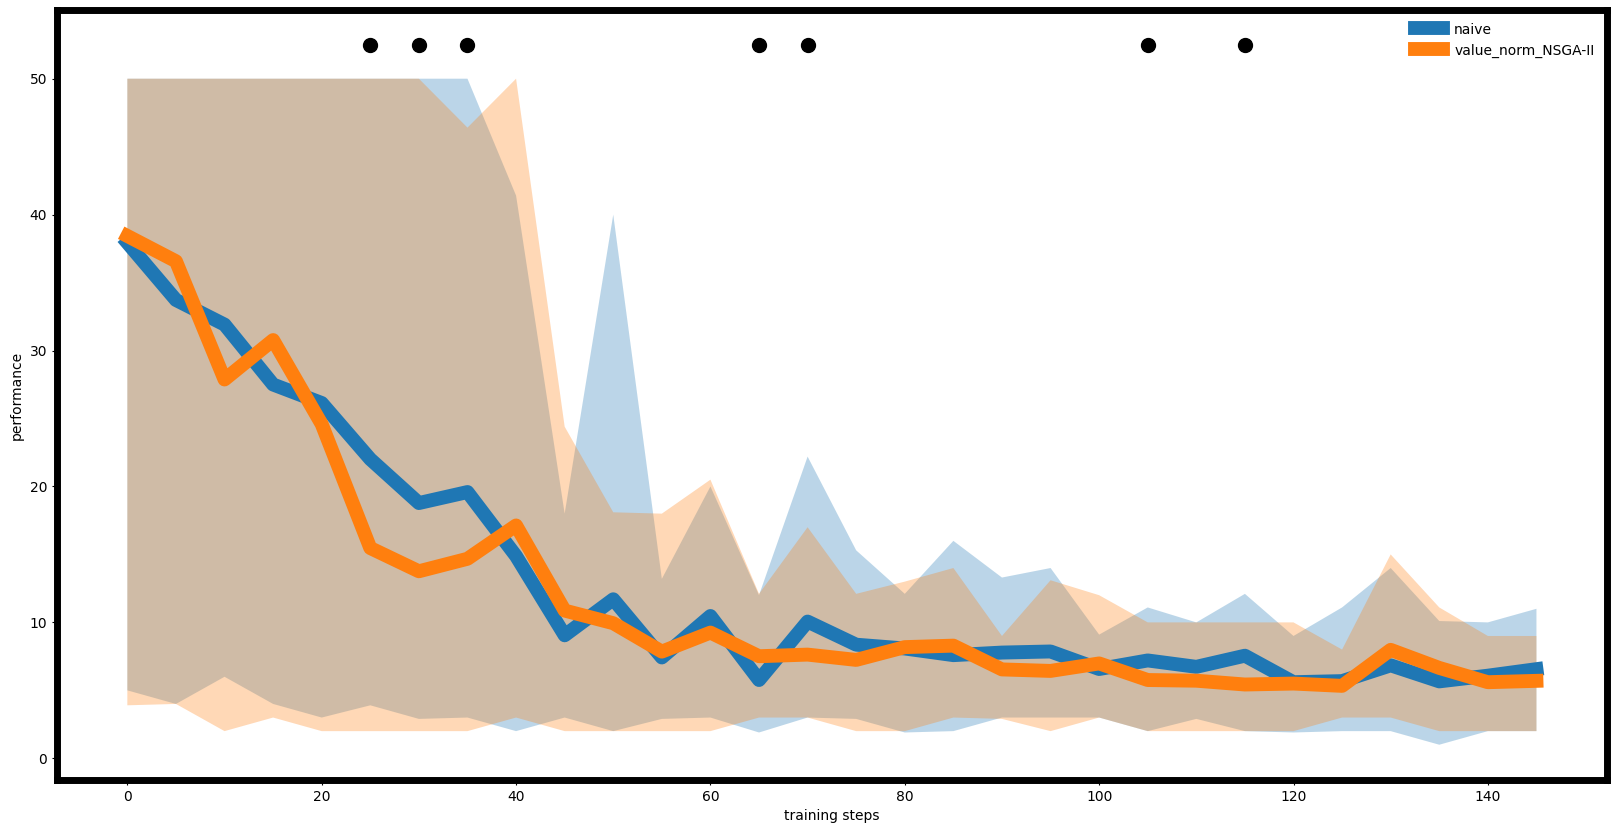

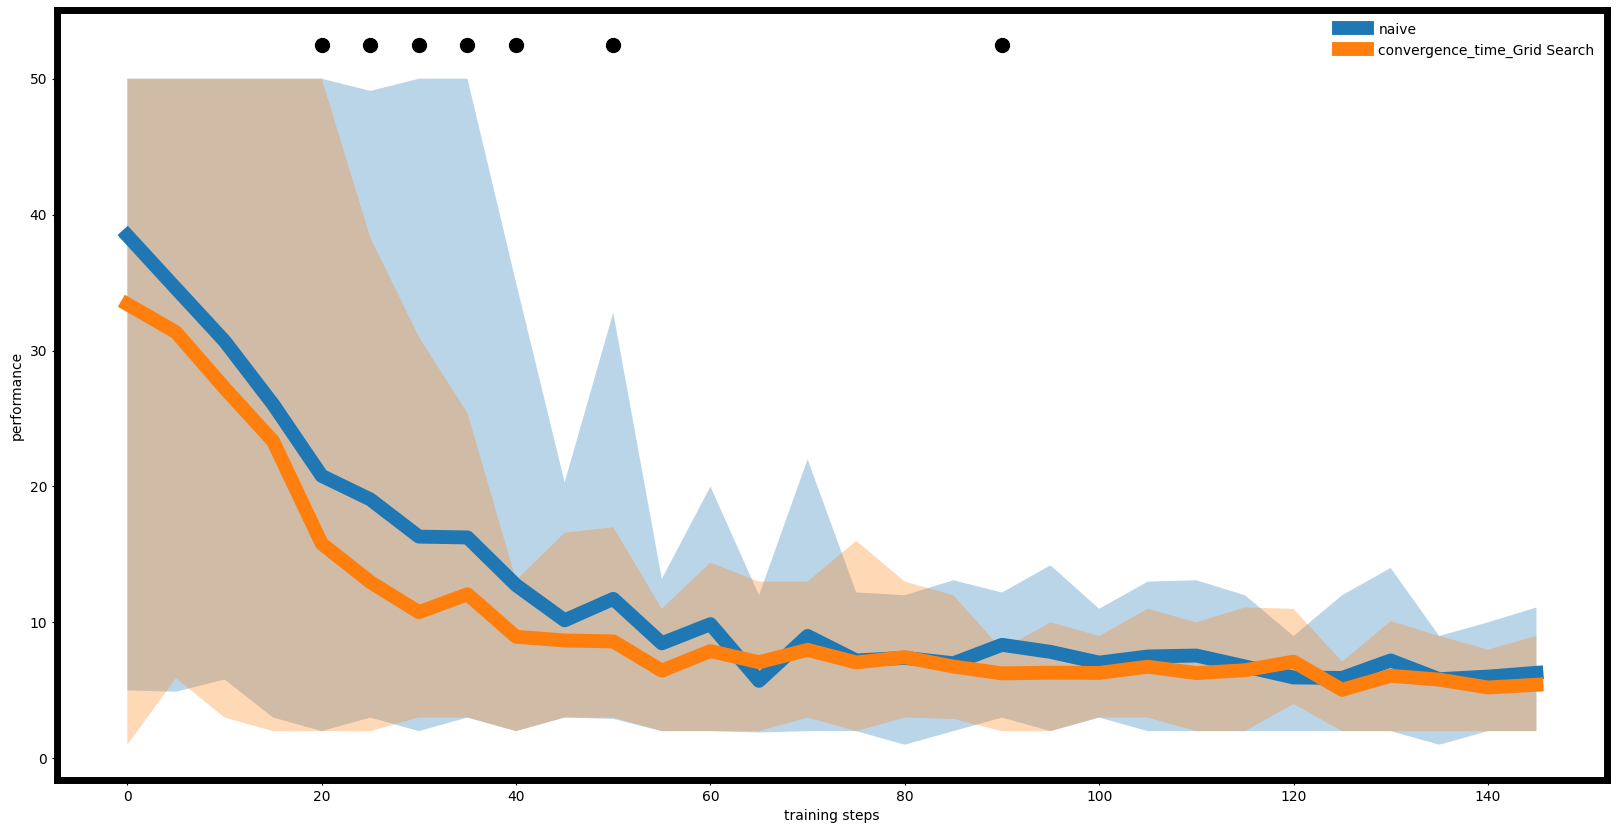

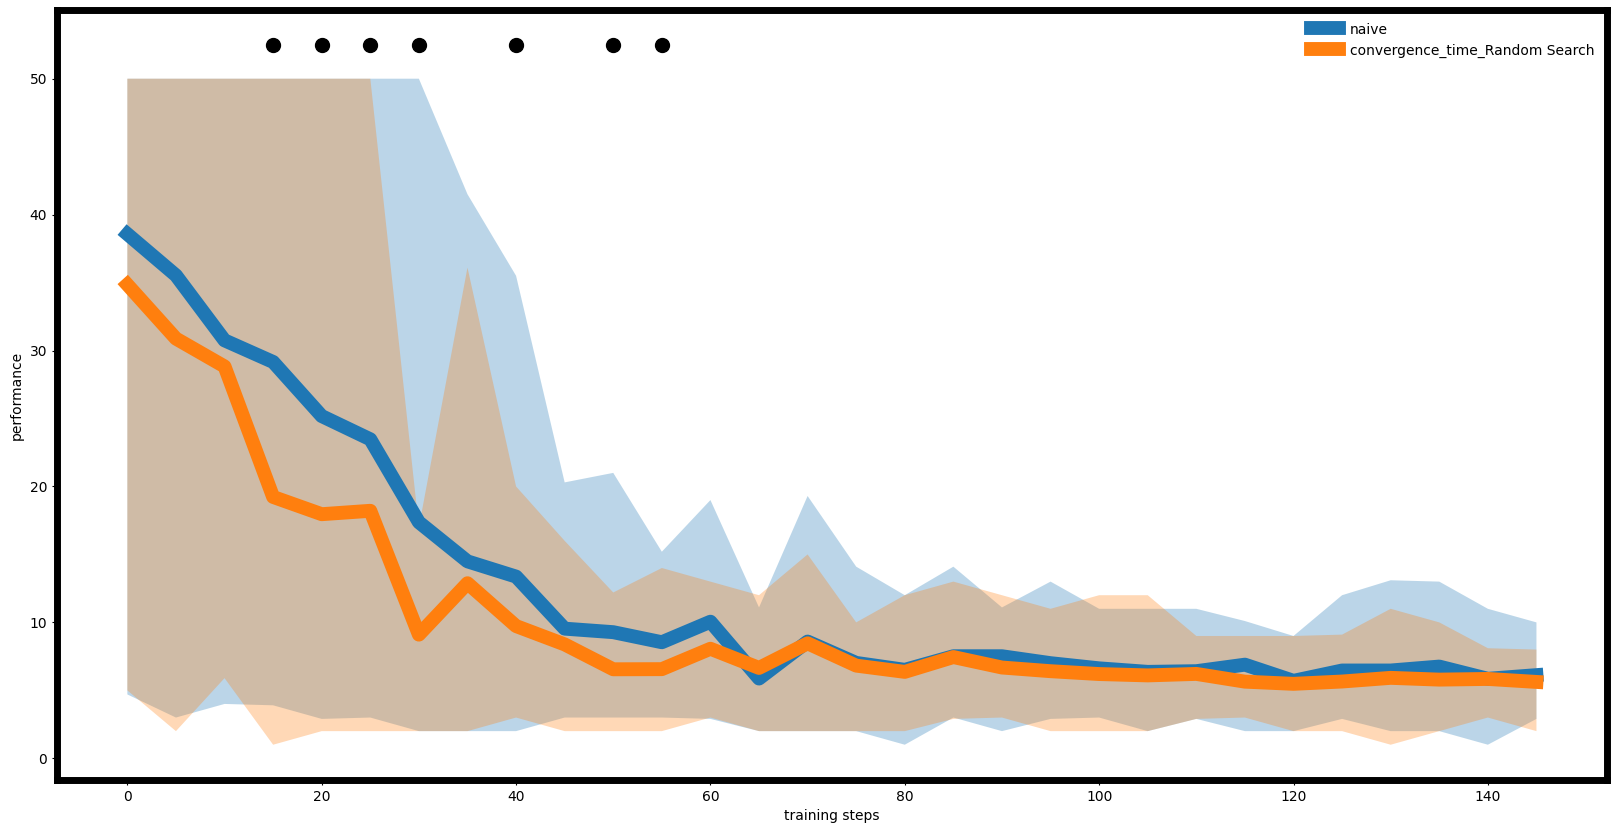

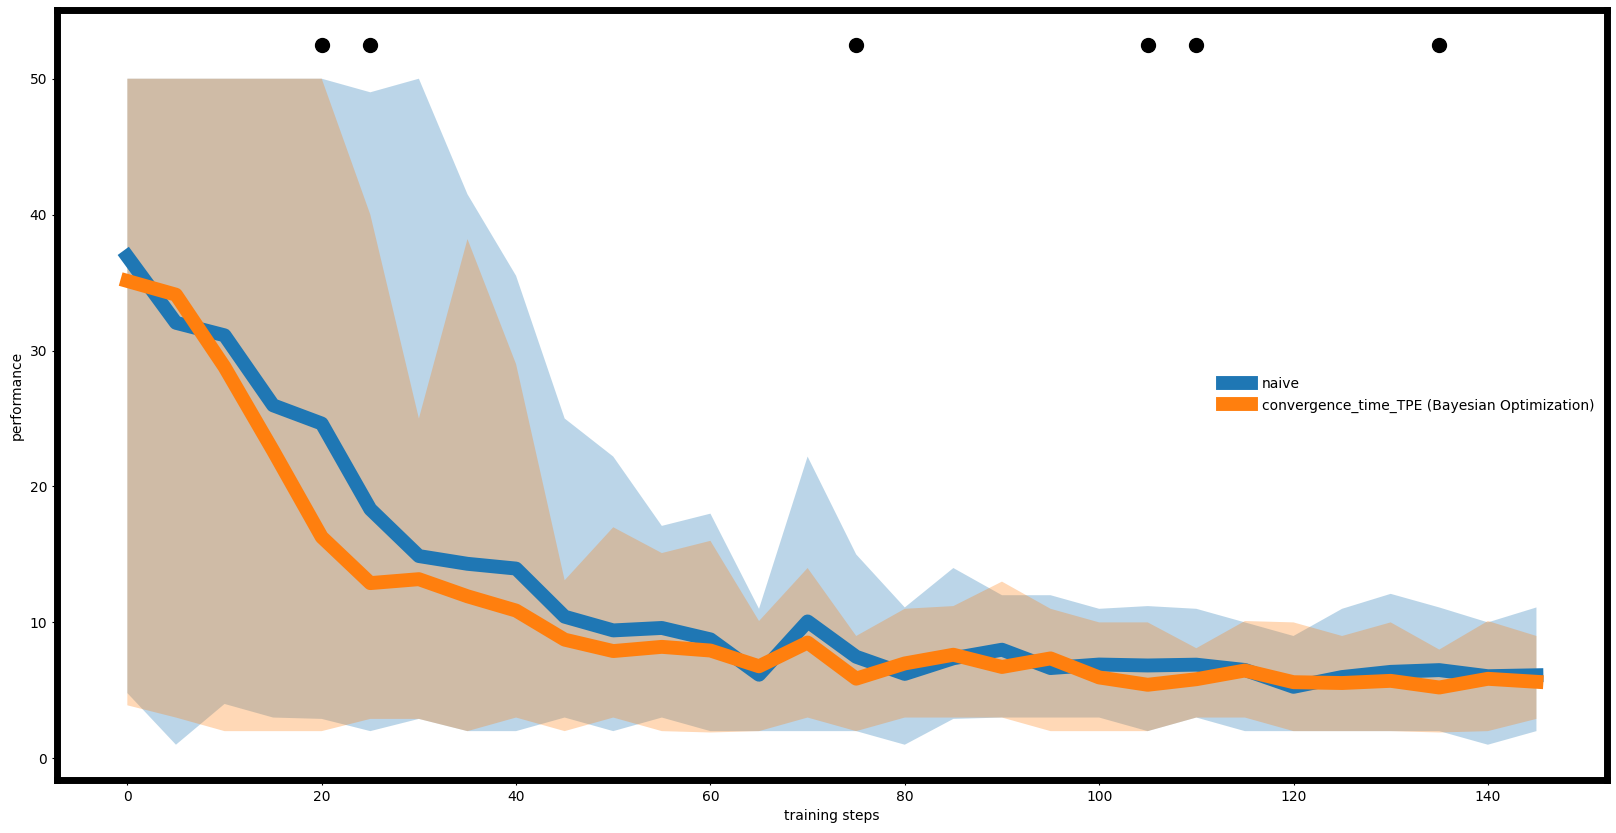

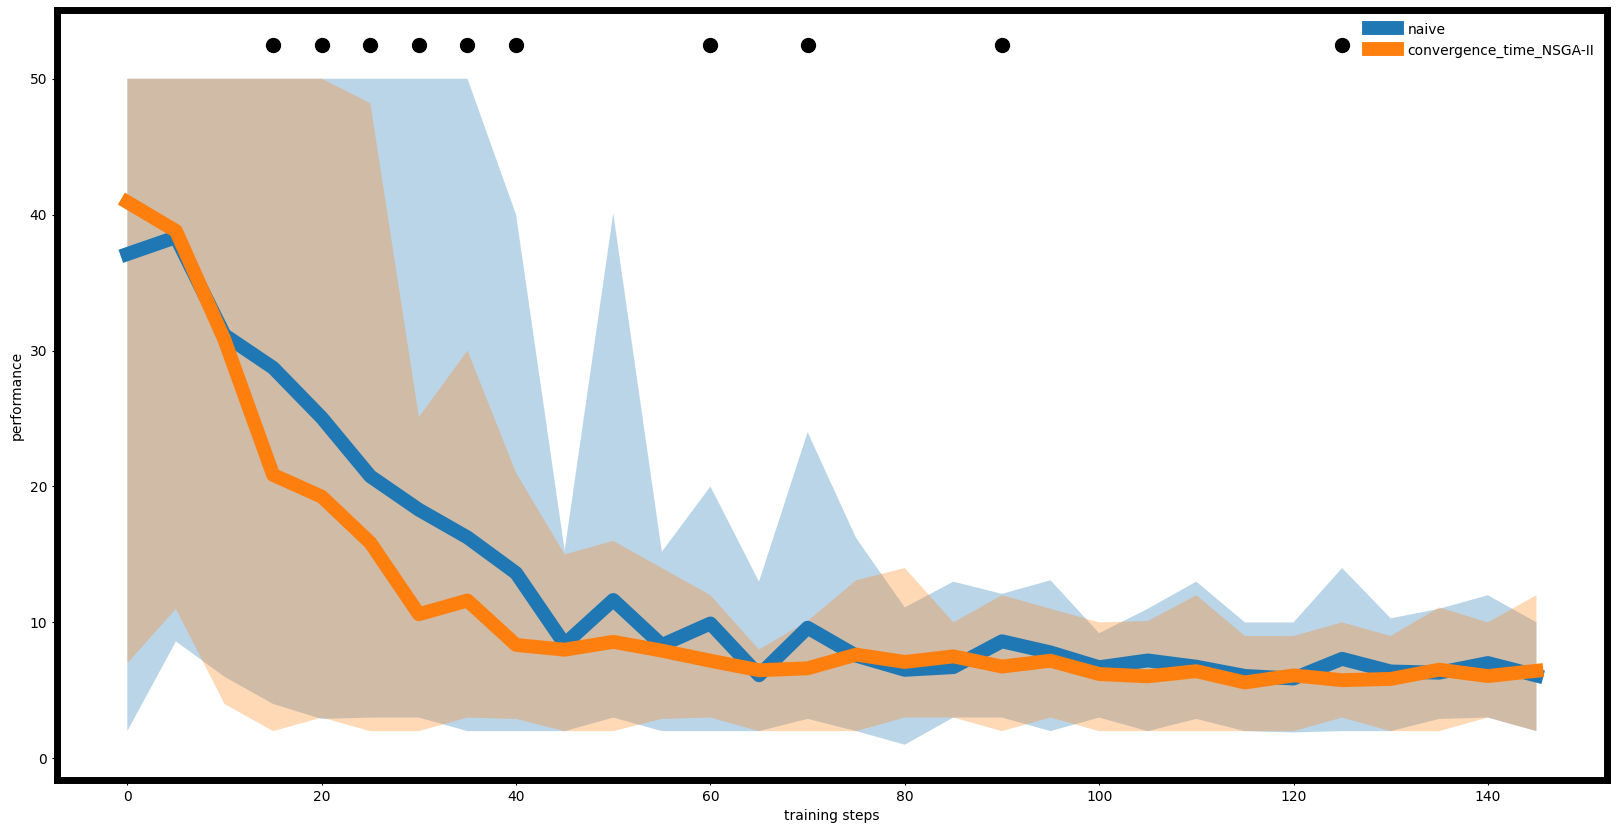

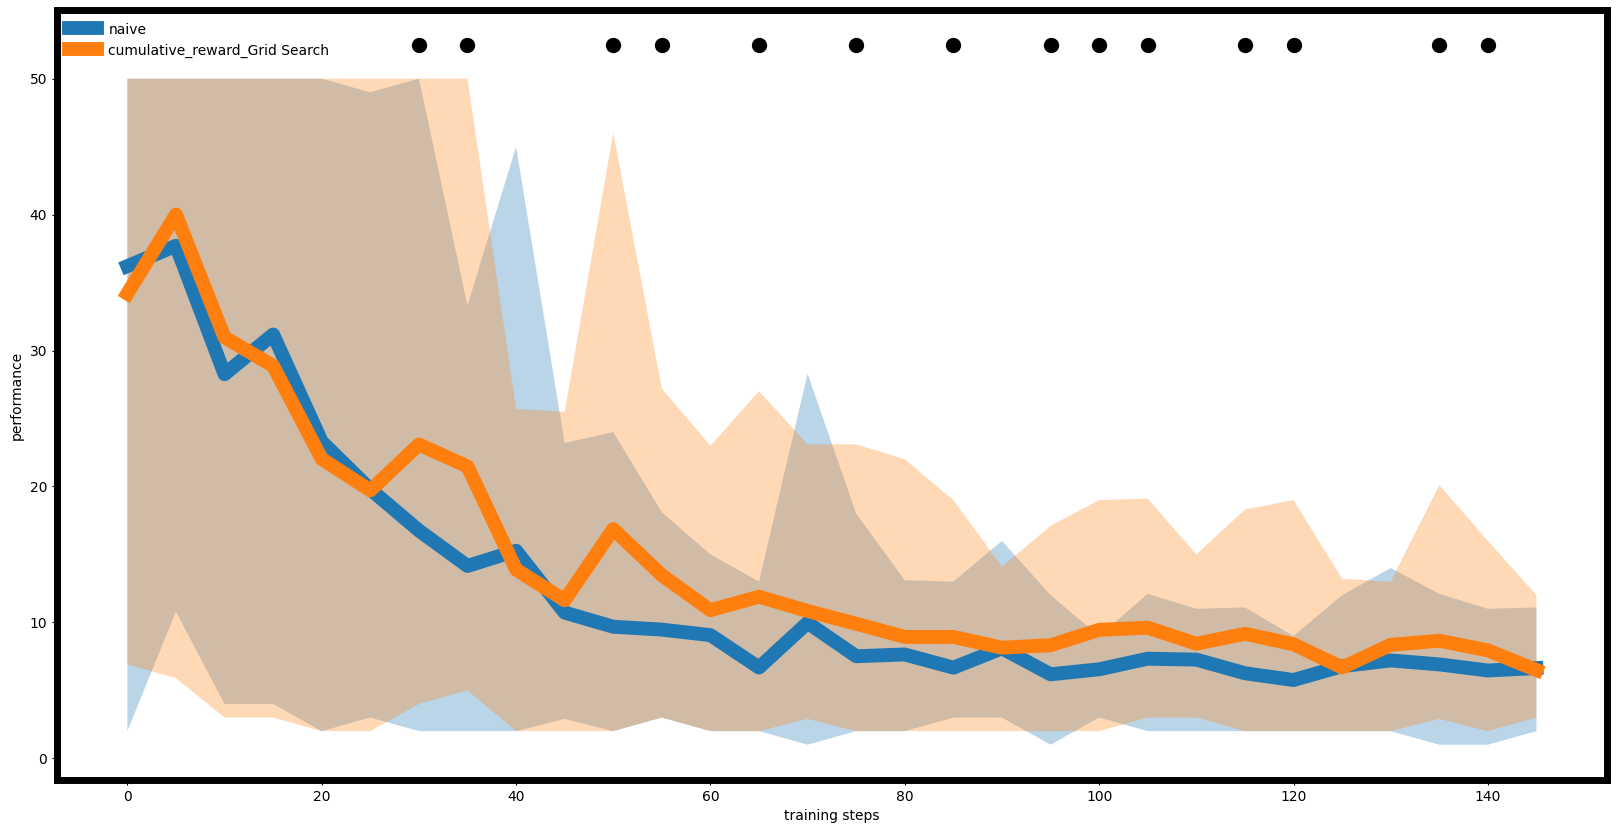

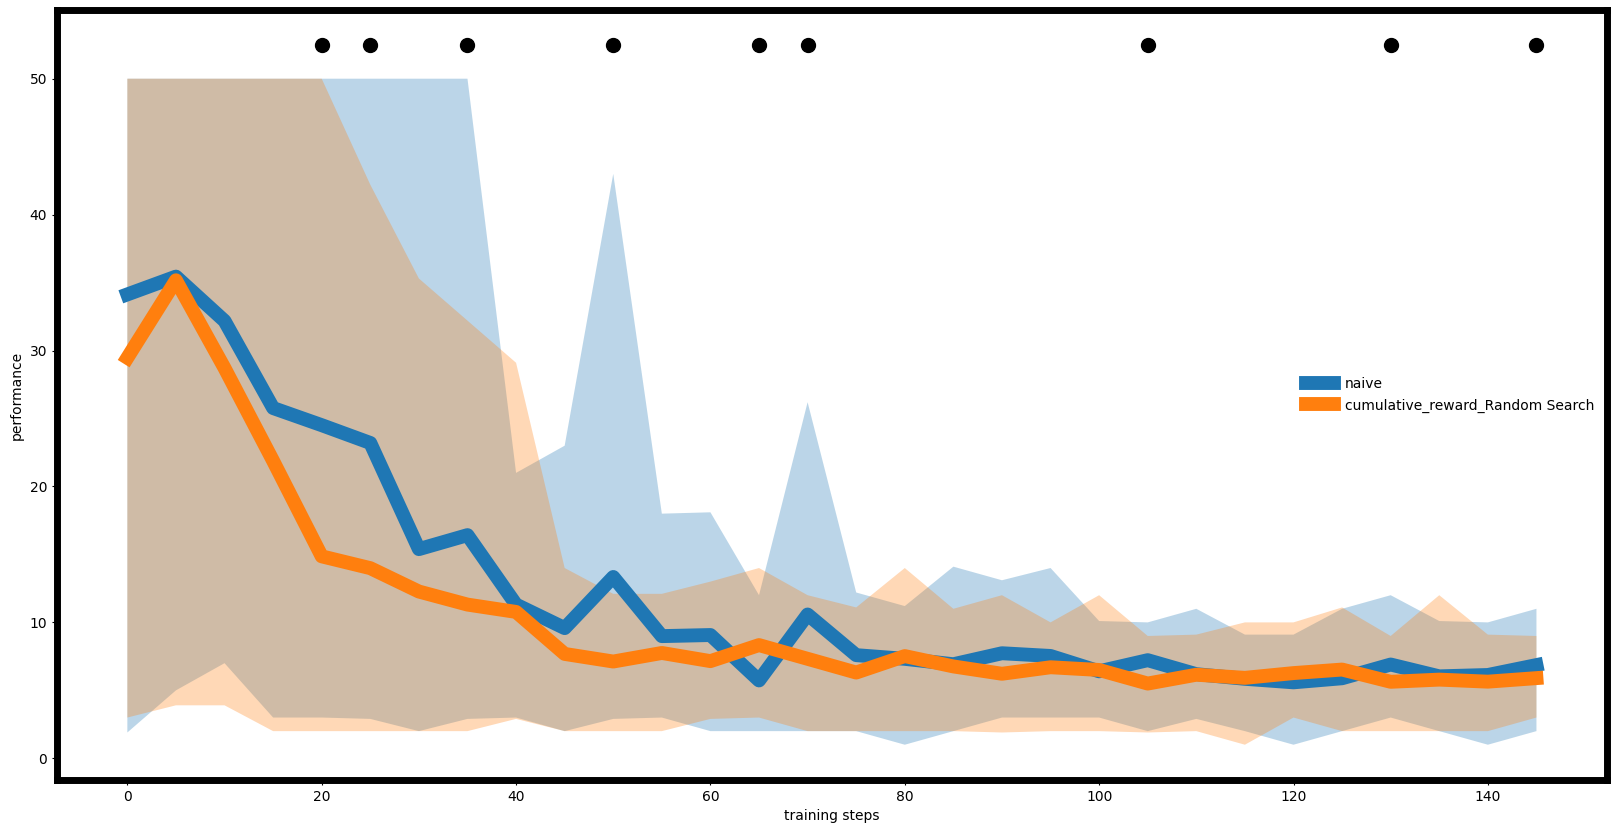

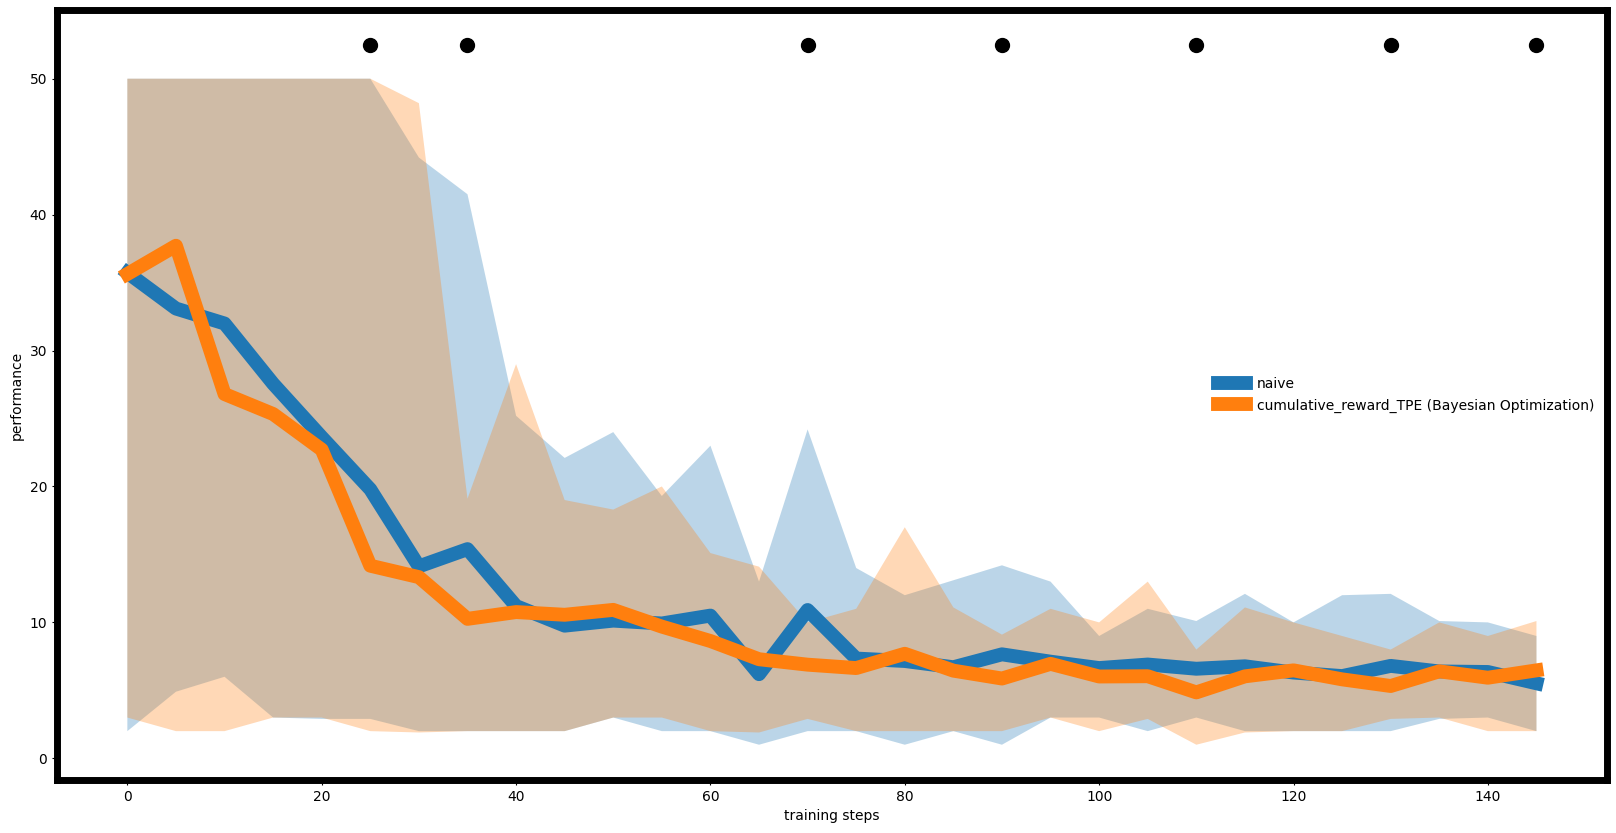

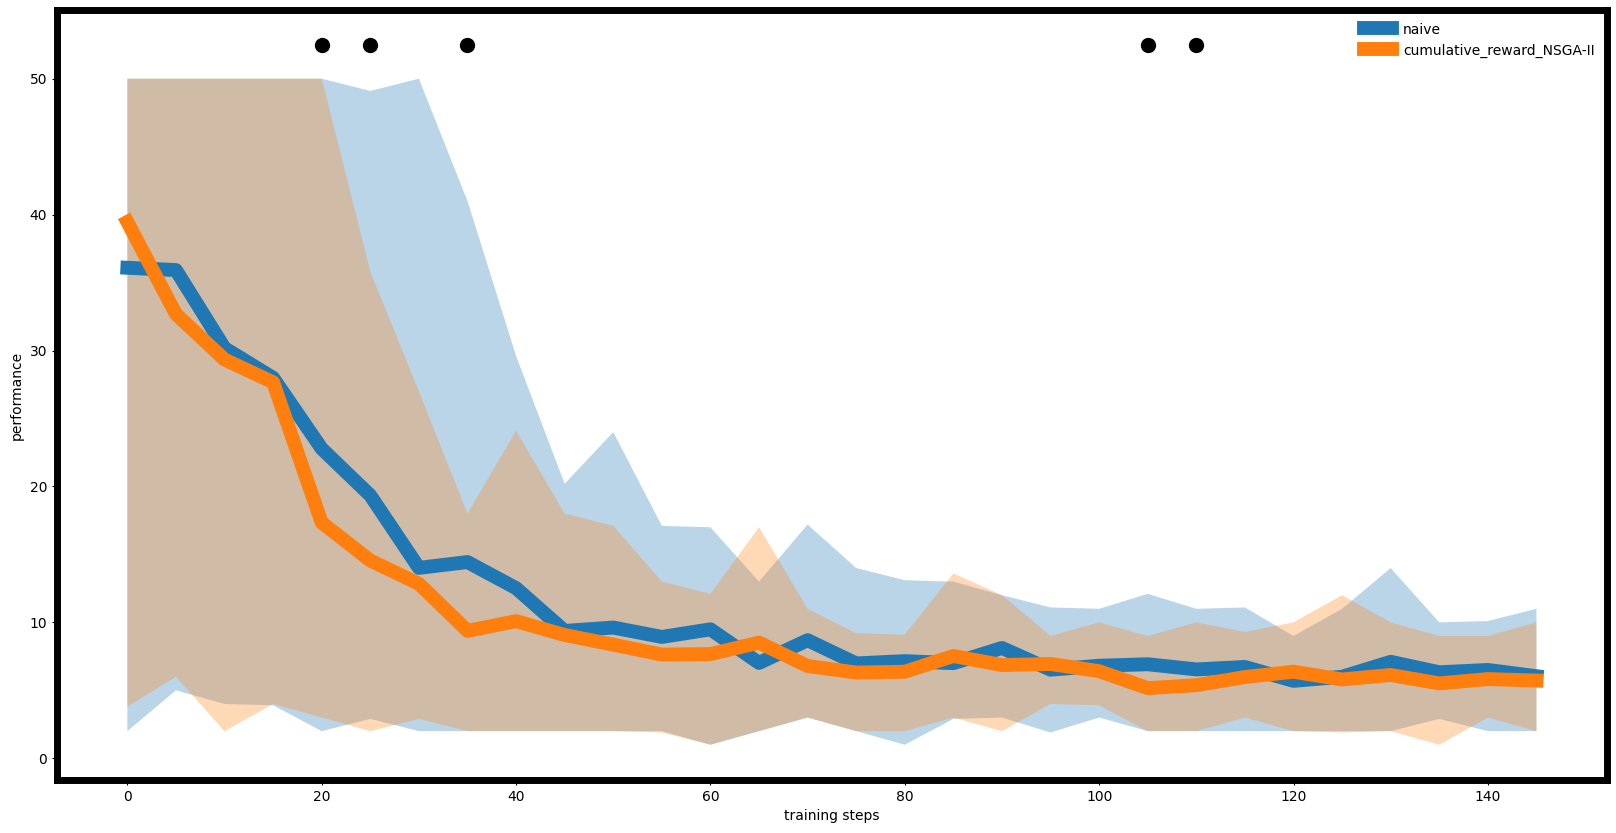

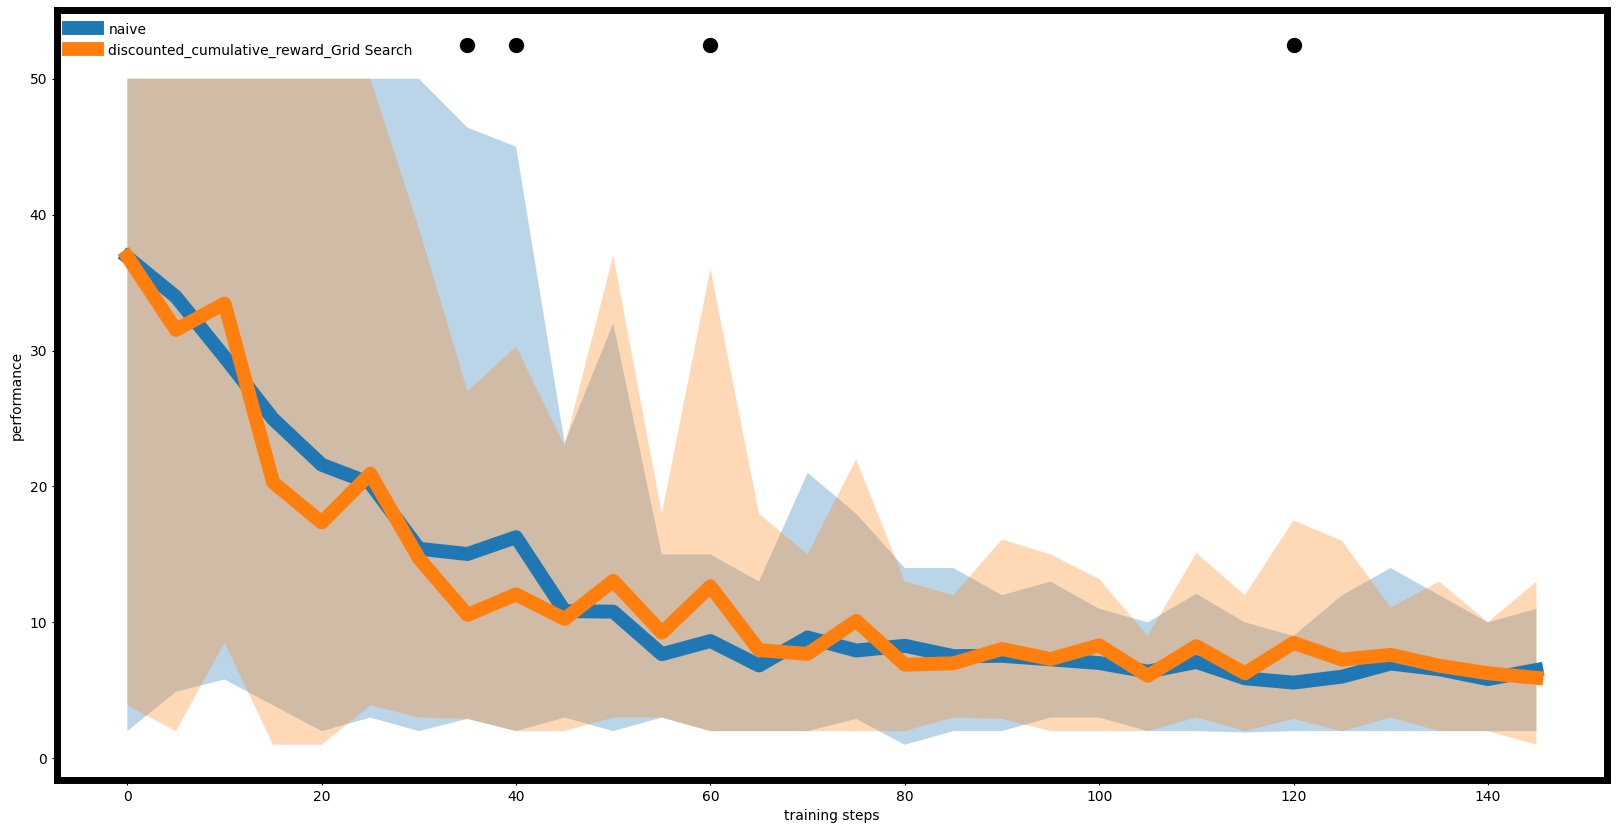

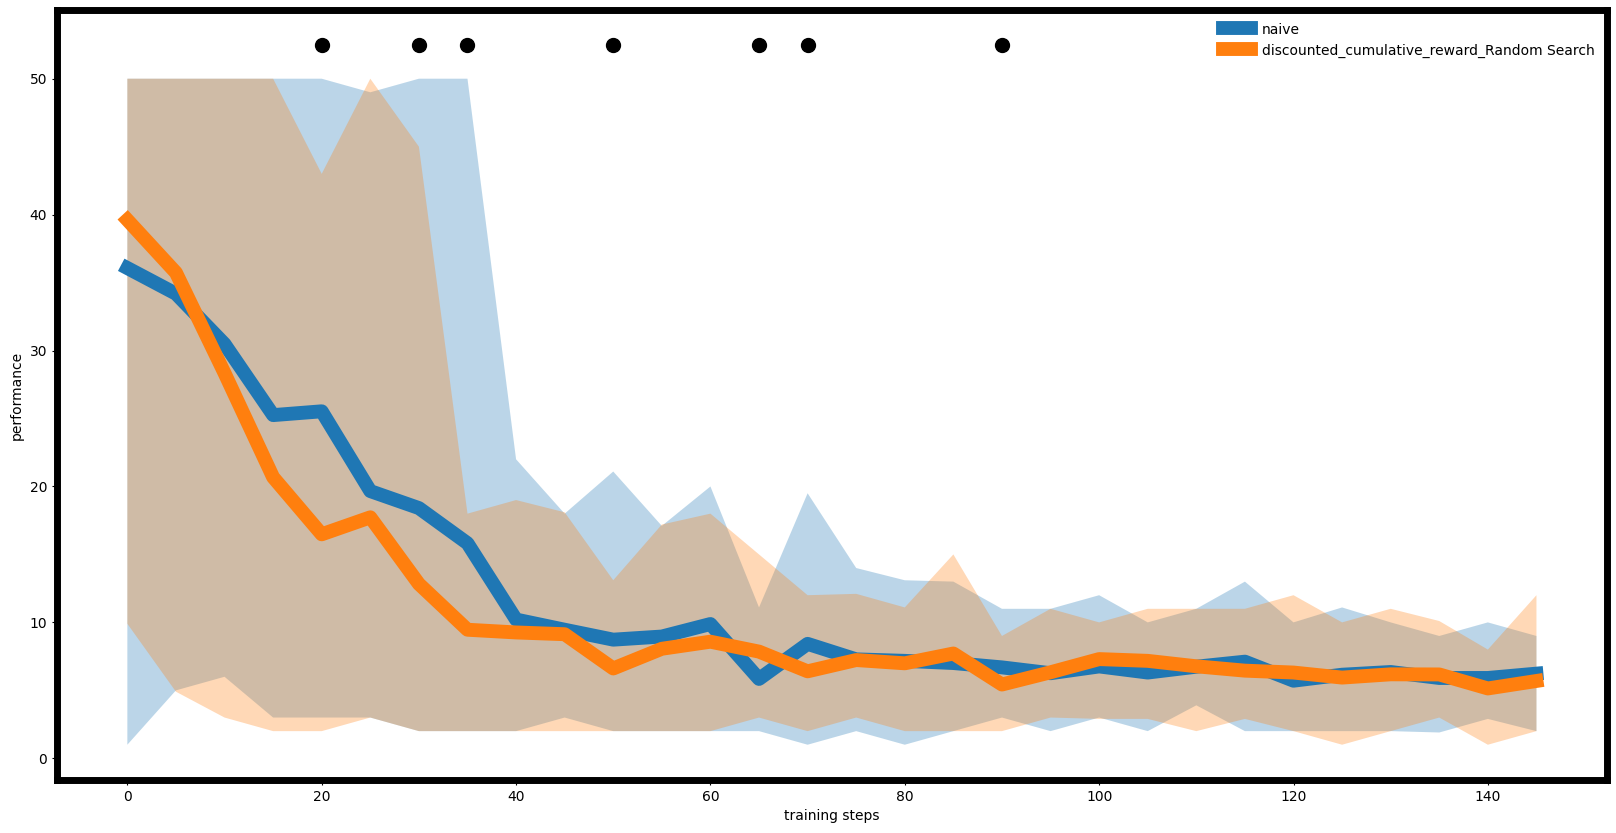

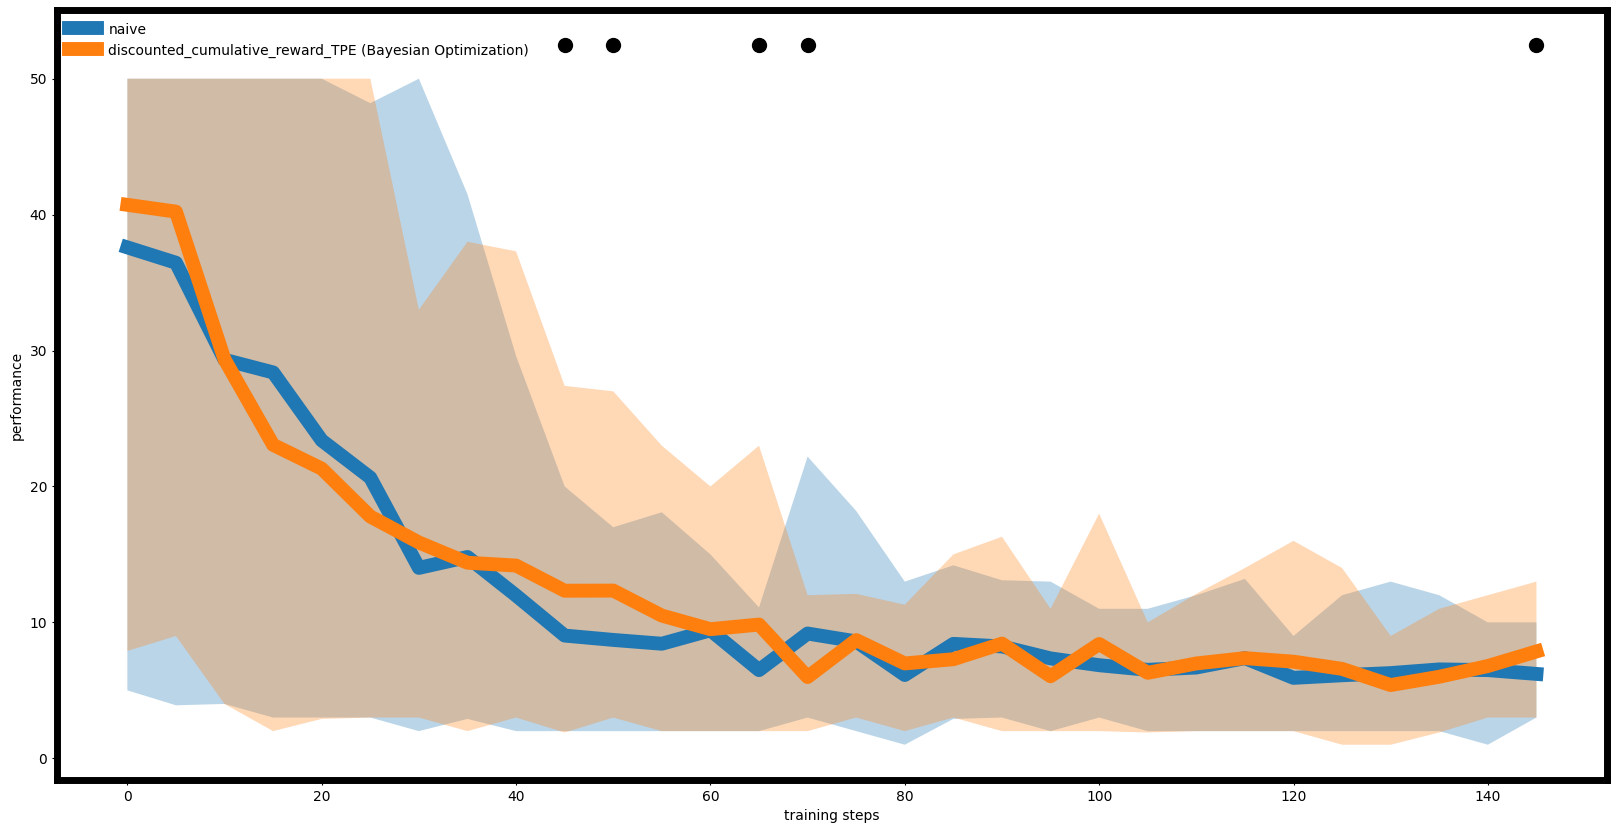

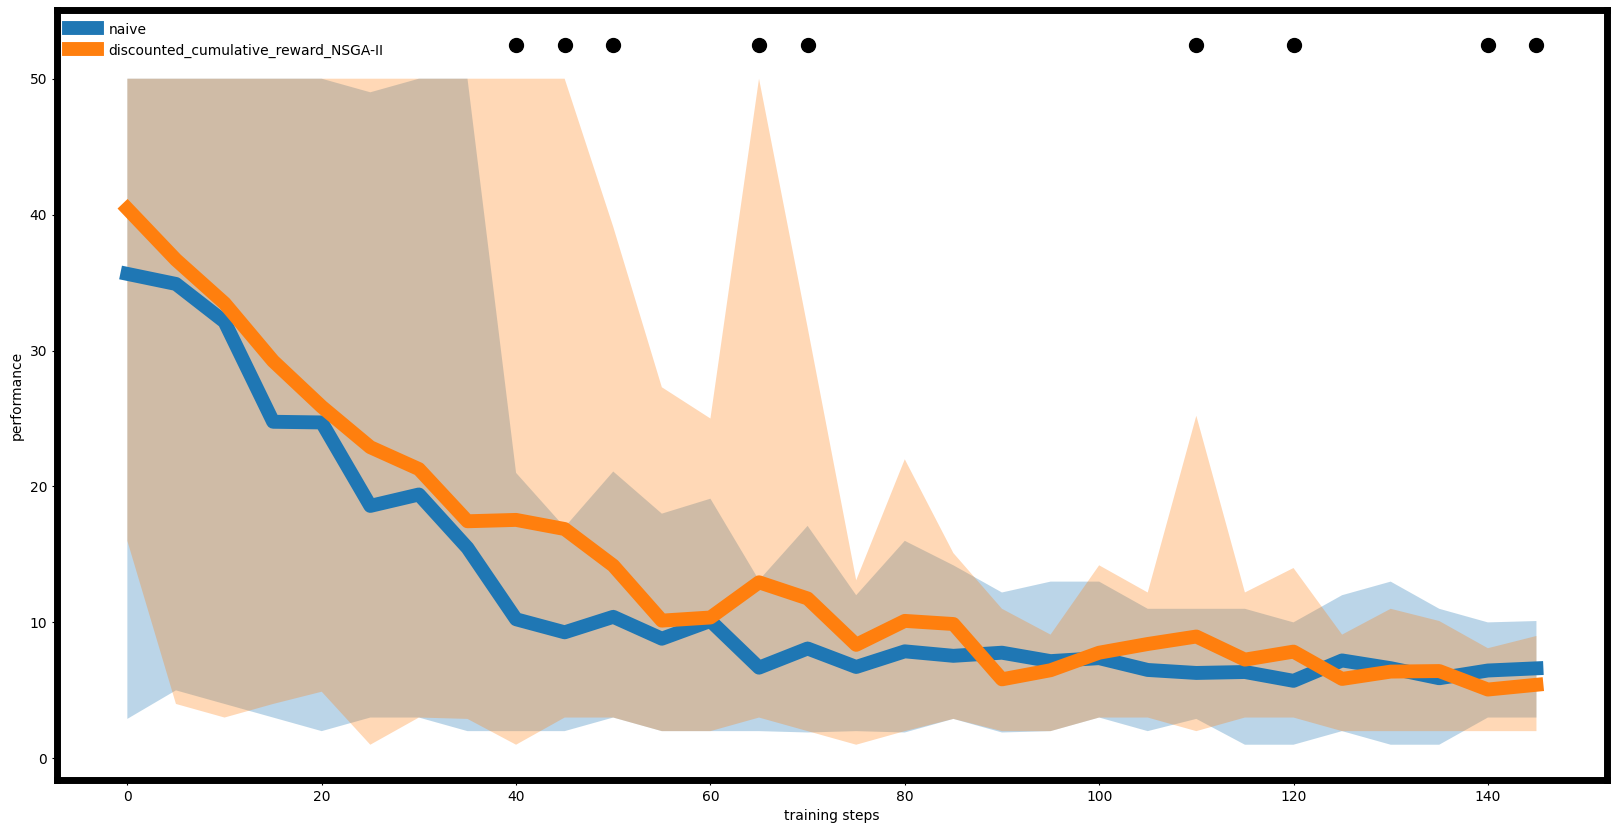

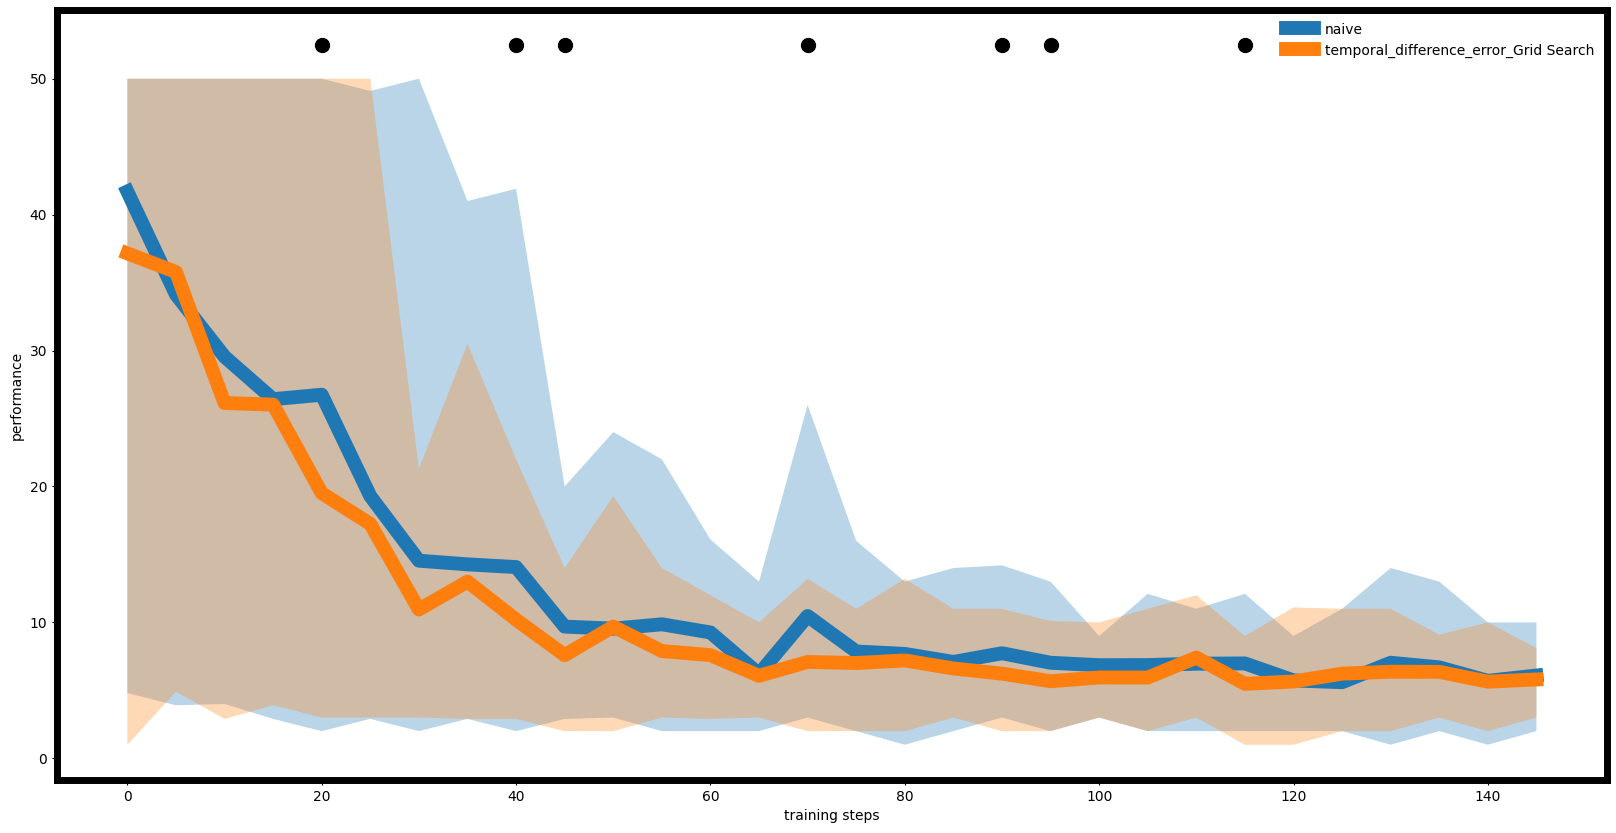

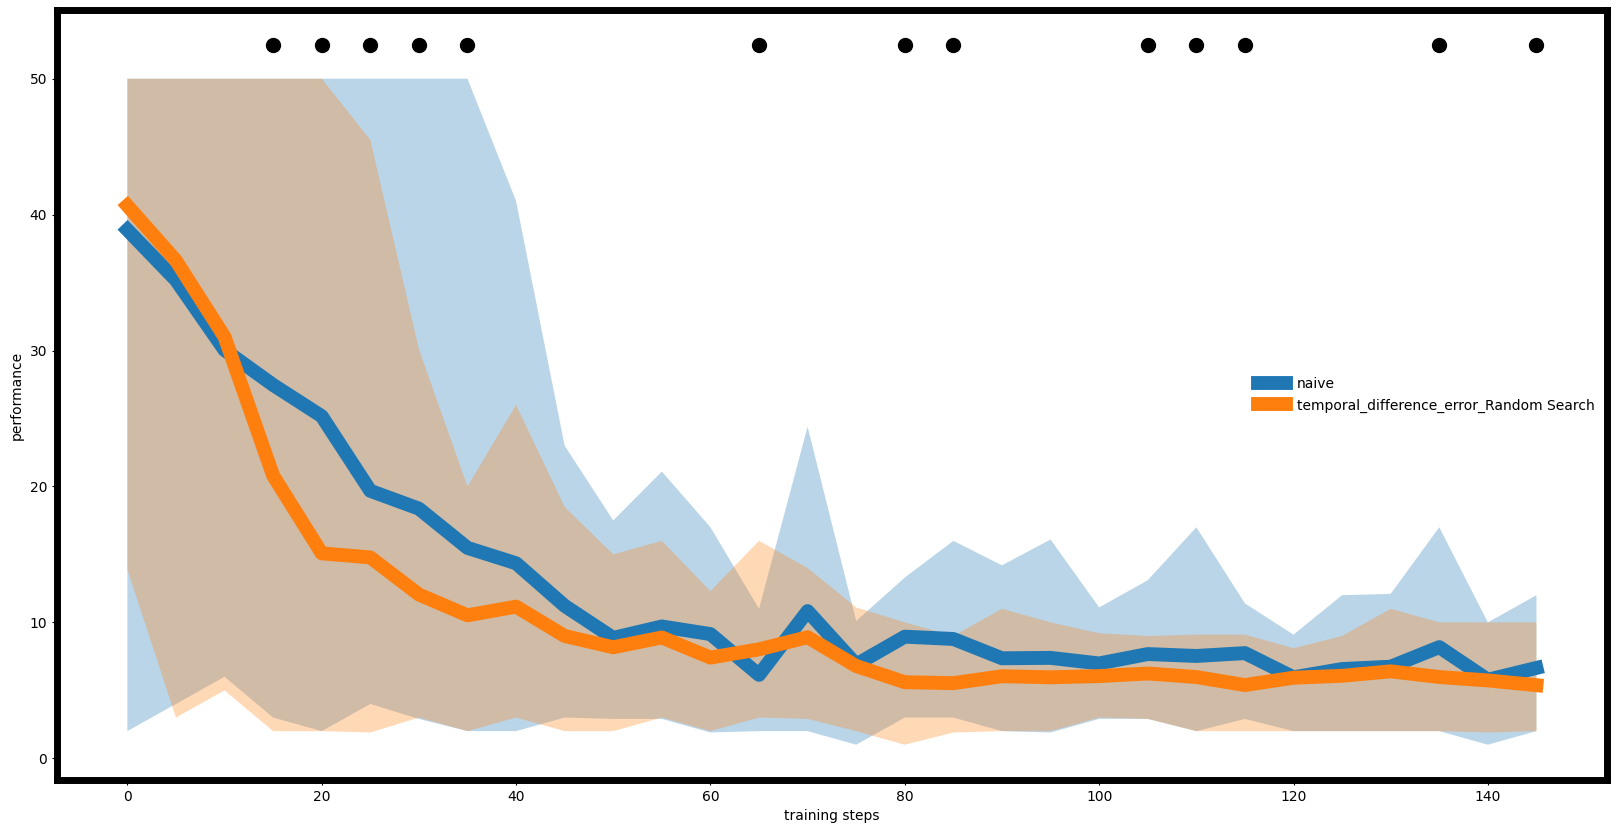

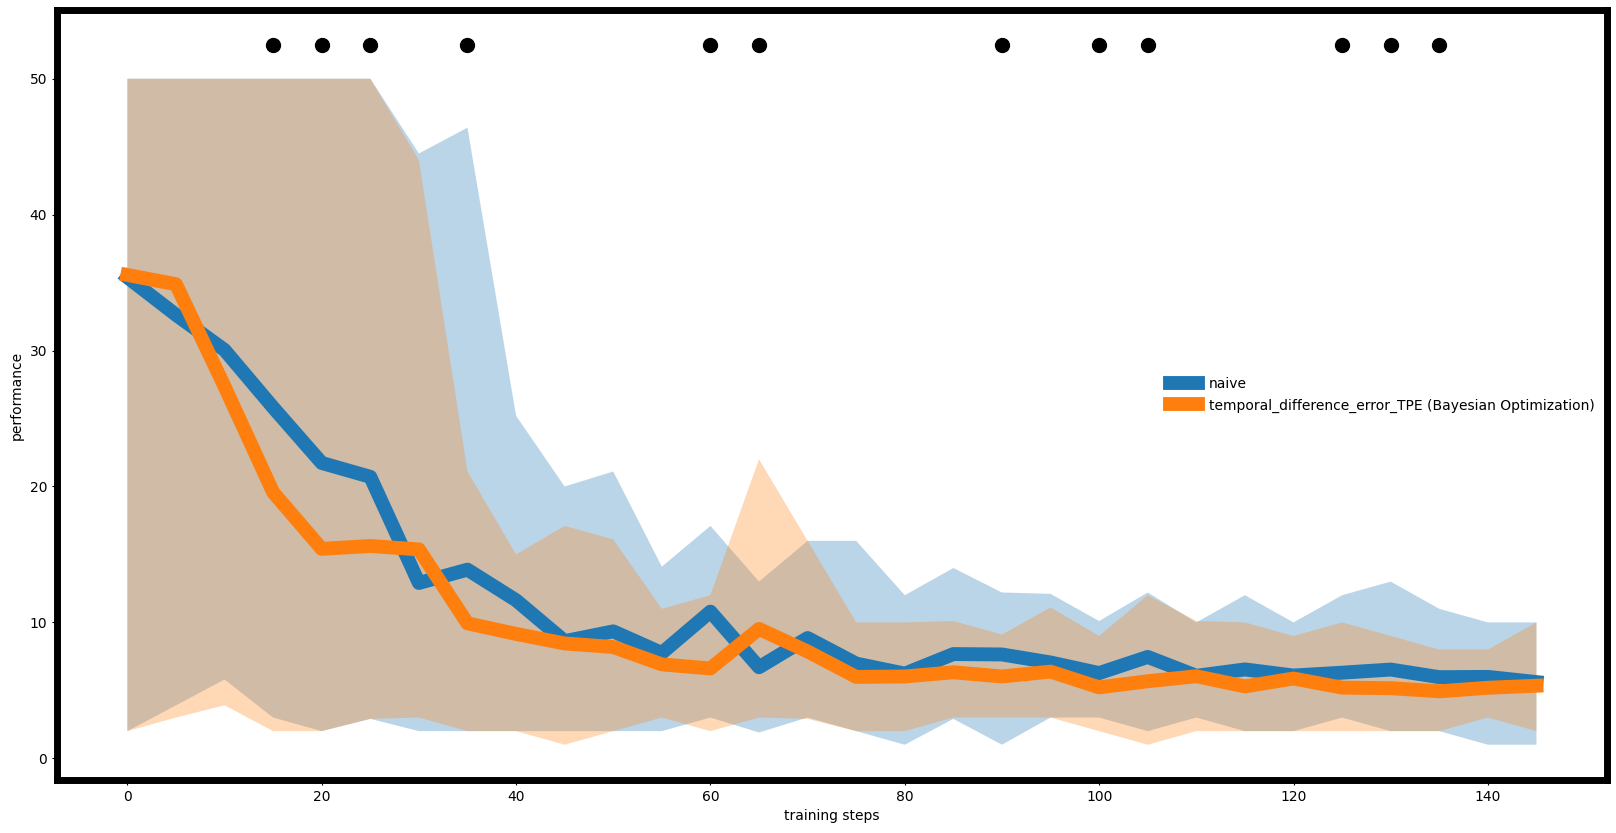

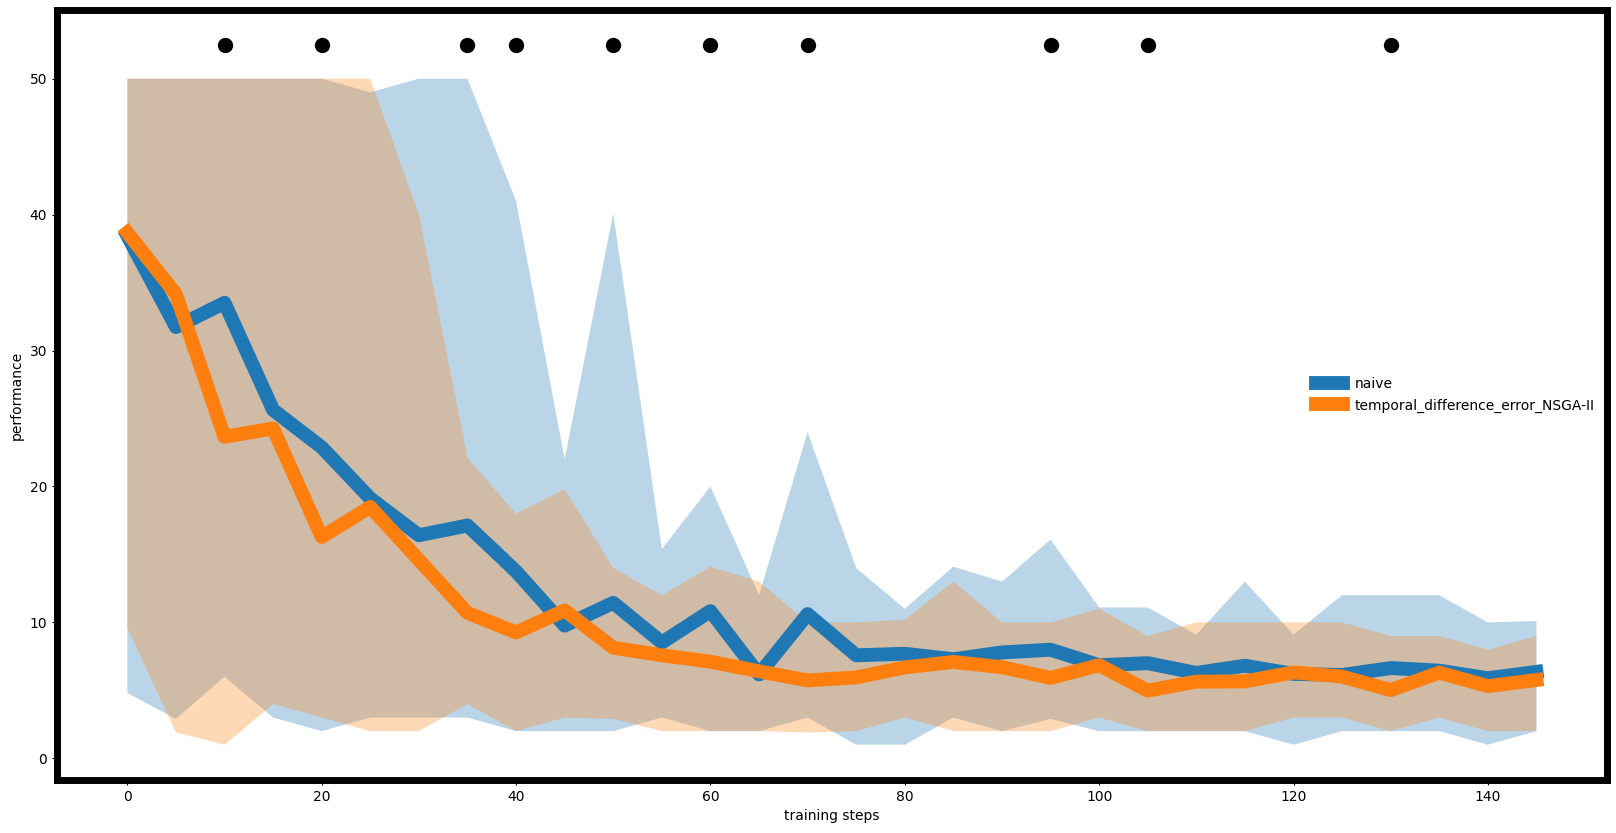

In [76]:

# Comparer chaque méthode avec la méthode naïve
naive_performance = learning_curves["naive"]

for result_key in learning_curves.keys():
    if result_key != "naive":
        print(f"Testing {result_key} vs naive...")

        # Récupérer les performances de l'algorithme optimisé
        optimized_performance = learning_curves[result_key]

        # Effectuer les tests statistiques entre les deux méthodes
        perform_test(
            naive_performance,
            optimized_performance,
            "naive",
            result_key,
            sample_size=100,  # Taille de l'échantillon à comparer
            downsampling_fact=5,  # Réduction des points à tracer
            confidence_level=0.05  # Niveau de confiance du test
        )

print("Statistical tests completed and plots saved.")